## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
# Dataframe for AB test data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


> This dataset is composed of:
> 1. Users who visit e-commerce site, recognizable by a unique id: user_id
> 2. The time at which the user visits the landing page: timestamp
> 3. The group of which the user is part, control (in general control is when you keep this user in the same experience as before) and treatment : group
> 4. The landing page on which the user ends up, old_page or new_page: landing_page
> 5. Information if the user was converted or not, 1 or 0: converted

First toughts: This type of dataset will allow us to find out the conversion rate of users and compare which is the landing page (old or new) that has the most succesful conversion rate. The control group experience can be compared with the treatment group's experience. It will also be possible to analyze the impact of the time of day on the conversion rate.

b. Use the cell below to find the number of rows in the dataset.

In [4]:
# Get number of rows and columns in the df
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
# Unique user id's in the df
df.user_id.nunique()

290584

>we find that user id(s) can be repeated accross the dataset as there are less user_id than number of rows. So, some of them came back during the AB test. Although, let's just check that the experience is not duplicated

In [6]:
# Check if duplicated rows in the dataset
df[df.duplicated()]

,user_id,timestamp,group,landing_page,converted


> no duplicated rows found

d. The proportion of users converted.

In [7]:
# Find proportion of users who converted at each test
# Assumption: each test is represented by one row
# Note: it means that if a user comes back and is converted several times
# then, we count it too
p = round(df.converted.sum()/df.shape[0],2) 
p

0.12

e. The number of times the `new_page` and `treatment` don't match.

In [8]:
#In order to get a broader perspective on the tests

# Check how much each group lands on the new page
print("Users who land on *New page*:")
print(df.query('landing_page == "new_page"').groupby('group').size())
print('_____________________')
# Check how much each group lands on the old page
print("Users who land on *Old page*:")
print(df.query('landing_page == "old_page"').groupby('group').size())

Users who land on *New page*:
group
control        1928
treatment    145311
dtype: int64
_____________________
Users who land on *Old page*:
group
control      145274
treatment      1965
dtype: int64


In [9]:
# Number of times new_page and treatment do not match
df.query('landing_page == "new_page" & group == "control" | landing_page == "old_page" & group == "treatment" ').user_id.count()



3893

f. Do any of the rows have missing values?

In [10]:
df[df.isna().any(axis=1)]

,user_id,timestamp,group,landing_page,converted


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

> In order to not induce error in the analysis, we need to drop the rows that have inconsistant results. Indeed, the control group is supposed to be the group of users for which experience in the site stays the same, which means the control group should only land in old_page. And reversely, for the treatment group, it should only land in the new_page. Therefore, we do not want to alter the conversion rate calculation with errors in the experimentation. 

In [11]:
# Get index of rows to drop = rows where control group lands in new_page and treatment group lands in old page
index_to_drop = df.query('landing_page == "new_page" & group == "control" | landing_page == "old_page" & group == "treatment" ').index

# Drop the rows
df2 = df.drop(index_to_drop, axis = 0)
# Reset index to restart index count
df2.reset_index(drop = True, inplace= True)
# Check that the dataframe looks like we expect
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290585 entries, 0 to 290584
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.1+ MB


In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
# Check how many distinct user_id are there
df2.user_id.nunique()

290584

> When checking the df2.info() above, we see there are 290585 entries but there are only 290584 unique user_id. It means that one user_id is duplicated

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
# Which user_id is duplicated ?
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [15]:
# Which are the rows where the duplicated user_id appears ?
df2[df2['user_id'] == 773192 ]

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
# Drop one of the rows of the duplicated user
df2.drop([2862], axis = 0, inplace = True)

In [17]:
# Check that this user_id only has one row in the dataframe
df2[df2['user_id'] == 773192 ]

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
p_c = round(df2.converted.sum()/df2.shape[0],4)
p_c

0.1196

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
df2_con = df2[df2['group'] == "control"]
p_c_con = df2_con.converted.sum()/df2_con.shape[0]
p_c_con

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
df2_treat = df2[df2['group'] == "treatment"]
p_c_treat = df2_treat.converted.sum()/df2_treat.shape[0]
p_c_treat

0.11880806551510564

d. What is the probability that an individual received the new page?

In [21]:
df2.query('group == "treatment"').user_id.count()/df2.shape[0]

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**The new treatment page according to our probabilities is hardly showing any improvement at all compared with the old page. The probability to convert for people in the treatment group is 11.8% and for people in the control group, it is 12.0% which can be considered exactly the same probability of conversion whether the landing page is the new or the old one. There is no significant difference that we can consider at this point. In conclusion, there is no sufficient evidence that shows that there is a difference between old and new page conversion**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$ H_{0}: p_{new} - p_{old} ≤ 0 $$
$$ H_{1}: p_{new} - p_{old} > 0 $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [22]:
# The dataframe we use for this A/B test
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [23]:
# Compute the observed difference probability for users to convert 
# between new and old pages
obs_diff = p_c_treat - p_c_con

# Display observed difference
obs_diff

-0.0015782389853555567

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [24]:
p_new_null = round(df2.converted.sum()/df2.shape[0],4)
p_new_null

0.1196

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [25]:
p_old_null = p_new_null
p_old_null

0.1196

c. What is $n_{new}$, the number of individuals in the treatment group?

In [26]:
df2_new = df2[df2['group'] == "treatment"]
n_new = df2_new.user_id.nunique()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [27]:
df2_old = df2[df2['group'] == "control"]
n_old = df2_old.user_id.nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [28]:
new_page_converted = np.random.choice([0,1], size = n_new, p = [1 - p_new_null, p_new_null])

new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
old_page_converted = np.random.choice([0,1], size = n_old, p = [1 - p_old_null, p_old_null])

old_page_converted

array([1, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [30]:
p_new_sim = new_page_converted.sum()/len(new_page_converted)
p_old_sim = old_page_converted.sum()/len(old_page_converted)
p_new_sim - p_old_sim 

-0.0018398119595546825

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [31]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([0,1], size = n_new, p = [1 - p_new_null, p_new_null])
    old_page_converted = np.random.choice([0,1], size = n_old, p = [1 - p_old_null, p_old_null])
    p_new_sim = new_page_converted.sum()/len(new_page_converted)
    p_old_sim = old_page_converted.sum()/len(old_page_converted)
    p_diffs.append(p_new_sim - p_old_sim)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

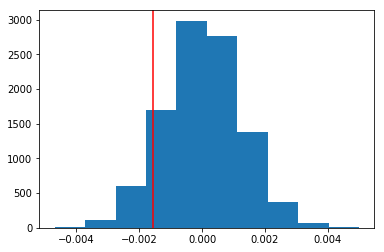

In [32]:
plt.hist(p_diffs);
plt.axvline( x = obs_diff, color = 'r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [33]:
(p_diffs > obs_diff).mean()

0.90329999999999999

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**We have been applying the Hypothesis testing technique in this part of the excercise. The hypothesis testing method is used in this case to identify whether a new feature in the website is going to have the expected outcome or not. We tested whether the new landing page has a better conversion rate than the old one. We used the null hypothesis assuming it is true in order to compare it to the observed value drawned from the data. In doing so, we obtain the p-value, the probability to obtain the observed statistic under the null hypothesis or one more extreme in favor of the alternative hypothesis. We compute the p-value by looking at more extreme values that could relate to the alternative hypothesis. Knowing the null hypothesis is that the new page conversion is equal or worse than the old page conversion, if the p-value is high, then there is high chances that the null hypothesis is True. So, our test bring us to the conclusion that the new page has a conversion equal or worse than the old page**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [34]:
import statsmodels.stats.proportion as sm

convert_old = df2_old.converted.sum()
convert_new = df2_new.converted.sum()
n_old = df2_old.shape[0]
n_new = df2_new.shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [35]:
stat, pval = sm.proportions_ztest(convert_new - convert_old, n_new -n_old)
print('{0:0.3f}'.format(pval))

ValueError: value must be provided for a 1-sample test

In [58]:
stat, pval = sm.proportions_ztest([convert_new,convert_old], [n_new, n_old])
print('{0:0.3f}'.format(pval))

0.190


In [59]:
sm.proportions_ztest([convert_new,convert_old], [n_new, n_old])

(-1.3109241984234394, 0.18988337448195103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])